In [1]:
!pip install -r requirements.txt
!unzip -o data.zip

## Download model and put in: /animated-character-type-classification/FlaskApp/flask_app/static/models
## Download data.zip and put in /animated-character-type-classification/

In [2]:
import torch
import pandas as pd
import numpy as np
import random
import pickle
import keras

import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, WeightedRandomSampler

from collections import Counter
from torchvision import datasets, transforms, models

from IPython import display

from keras import layers, models, optimizers

In [3]:
torch.cuda.is_available()

False

## Data Preprocessing
For data preprocessing, we:
1. Remove rows with invalid primary types
2. Drop unneeded columns
3. Extract the features and labels
4. Make train-test splits

There are 1008 data points, split 80-20 into train-test.

We try Decision Tree and SVM, and again using GridSearchCV to tune hyperparameters, since we found it easier than using a validation set.

Results are listed for test and train sets following the model training.

In [4]:
pokedex = pd.read_csv('data/Pokedex_Cleaned.csv', encoding='latin-1')
pokedex

,#,Name,Primary Type,Secondary Type,Total,HP,Attack,Defense,Sp.Atk,Sp.Def,Speed,Variant
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,NaN
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,NaN
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,NaN
3,3,Venusaur,Grass,Poison,625,80,100,123,122,120,80,NaN
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1168,1004,Chi-Yu,Dark,Fire,570,55,80,80,135,120,100,NaN
1169,1005,Roaring Moon,Dragon,Dark,590,105,139,71,55,101,119,NaN
1170,1006,Iron Valiant,Fairy,Fighting,590,74,130,90,120,60,116,NaN
1171,1007,Koraidon,Fighting,Dragon,670,100,135,115,85,100,135,NaN


In [5]:
primary_types = pokedex['Primary Type']
not_types = {"Null", "Male", "Female", "Rockruff"}
pokedex = pokedex.loc[~pokedex['Primary Type'].isin(not_types)]  # remove rows with invalid types
primary_types = pokedex['Primary Type']
primary_types.value_counts()  # bad rows are gone

Primary Type
Water       147
Normal      130
Grass       102
Bug          99
Psychic      76
Fire         73
Electric     73
Rock         67
Dark         56
Ground       47
Dragon       47
Fighting     46
Poison       46
Ghost        46
Steel        42
Fairy        32
Ice          27
Flying       12
Name: count, dtype: int64

In [6]:
# Drop irrelevant rows, columns, reorder name
pokemon_names = pokedex['Name'].copy()
pokedex_relevant = pokedex.drop(['#', 'Name', 'Secondary Type', 'Total', 'Variant'], axis=1)
pokedex_relevant['Name'] = pokemon_names
pokedex_relevant = pokedex_relevant.drop_duplicates(subset=["Name"], keep='last')
pokedex_relevant.Name.tolist()

['Bulbasaur',
 'Ivysaur',
 'Venusaur',
 'Charmander',
 'Charmeleon',
 'Charizard',
 'Squirtle',
 'Wartortle',
 'Blastoise',
 'Caterpie',
 'Metapod',
 'Butterfree',
 'Weedle',
 'Kakuna',
 'Beedrill',
 'Pidgey',
 'Pidgeotto',
 'Pidgeot',
 'Rattata',
 'Raticate',
 'Spearow',
 'Fearow',
 'Ekans',
 'Arbok',
 'Pikachu',
 'Raichu',
 'Sandshrew',
 'Sandslash',
 'Nidorina',
 'Nidoqueen',
 'Nidoran?',
 'Nidorino',
 'Nidoking',
 'Clefairy',
 'Clefable',
 'Vulpix',
 'Ninetales',
 'Jigglypuff',
 'Wigglytuff',
 'Zubat',
 'Golbat',
 'Oddish',
 'Gloom',
 'Vileplume',
 'Paras',
 'Parasect',
 'Venonat',
 'Venomoth',
 'Diglett',
 'Dugtrio',
 'Meowth',
 'Persian',
 'Psyduck',
 'Golduck',
 'Mankey',
 'Primeape',
 'Growlithe',
 'Arcanine',
 'Poliwag',
 'Poliwhirl',
 'Poliwrath',
 'Abra',
 'Kadabra',
 'Alakazam',
 'Machop',
 'Machoke',
 'Machamp',
 'Bellsprout',
 'Weepinbell',
 'Victreebel',
 'Tentacool',
 'Tentacruel',
 'Geodude',
 'Graveler',
 'Golem',
 'Ponyta',
 'Rapidash',
 'Slowpoke',
 'Slowbro',
 'Mag

In [7]:
# extract features and labels
features = pokedex_relevant.iloc[:, 1:-1].values.astype(float)
# normalize numbers
for feature in features:
    s = sum(feature)
    feature /= s
labels = pokedex_relevant.iloc[:, 0].values
features, labels

(array([[0.14150943, 0.15408805, 0.15408805, 0.20440252, 0.20440252,
         0.14150943],
        [0.14814815, 0.15308642, 0.15555556, 0.19753086, 0.19753086,
         0.14814815],
        [0.128     , 0.16      , 0.1968    , 0.1952    , 0.192     ,
         0.128     ],
        ...,
        [0.12542373, 0.22033898, 0.15254237, 0.20338983, 0.10169492,
         0.19661017],
        [0.14925373, 0.20149254, 0.17164179, 0.12686567, 0.14925373,
         0.20149254],
        [0.14925373, 0.12686567, 0.14925373, 0.20149254, 0.17164179,
         0.20149254]]),
 array(['Grass', 'Grass', 'Grass', ..., 'Fairy', 'Fighting', 'Electric'],
       dtype=object))

In [8]:
# train test splits -- stats
# Stratify on labels to ensure each class has equal proportions
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, stratify=labels, random_state=42)

## Decision Tree Approach using Entropy

In [9]:
# Decision tree with entropy
clf_entropy = DecisionTreeClassifier(
        criterion = "entropy")
# Performing training
entropy_model = clf_entropy.fit(X_train, y_train)

# Prediction using entropy, display results

print("For test set:")
y_pred = entropy_model.predict(X_test)
print("Confusion Matrix: ",
confusion_matrix(y_test, y_pred))

print ("Accuracy : ",
accuracy_score(y_test,y_pred)*100)

print("Report : ",
classification_report(y_test, y_pred))

print("For train set:")
y_pred = entropy_model.predict(X_train)
print("Confusion Matrix: ",
confusion_matrix(y_train, y_pred))

print ("Accuracy : ",
accuracy_score(y_train,y_pred)*100)  # high train accuracy but low test accuracy... potentially overfitting?

print("Report : ",
classification_report(y_train, y_pred))

For test set:
Confusion Matrix:  [[4 0 0 2 1 0 1 0 0 3 1 0 1 1 1 1 2 0]
 [0 2 1 0 0 1 0 0 0 2 0 0 2 0 0 1 0 0]
 [0 0 1 3 0 0 0 0 0 0 1 0 1 0 0 1 0 0]
 [0 0 2 3 0 0 0 0 0 0 0 0 3 1 1 0 1 1]
 [0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 3]
 [0 0 1 0 1 3 0 0 0 1 1 0 1 0 0 0 0 0]
 [2 1 2 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1 2 0 0 1]
 [1 1 1 1 0 1 0 0 0 7 0 0 2 0 1 0 0 4]
 [1 1 1 1 0 0 0 0 0 0 3 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 1 0 0]
 [0 0 2 1 0 2 0 0 0 0 3 0 7 3 0 1 0 4]
 [0 0 0 0 1 0 0 1 0 2 0 0 3 1 0 0 0 0]
 [1 0 0 1 1 1 0 0 0 4 0 0 0 0 2 1 0 1]
 [2 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 5]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1]
 [1 0 1 1 1 0 2 2 0 3 1 1 5 1 1 1 2 4]]
Accuracy :  20.792079207920793
Report :                precision    recall  f1-score   support

         Bug       0.31      0.22      0.26        18
        Dark       0.40      0.22      0.29         9
      Dragon       0.08      0.14      0.11         7
    El

# SVM

In [10]:
svc_class = SVC(kernel='rbf')

# SVM training
svm_model = svc_class.fit(X_train,y_train)

# Prediction 
print("For test set:")
y_pred = svm_model.predict(X_test)
print("Confusion Matrix: ", "\n",
confusion_matrix(y_test, y_pred))

print ("Accuracy : ",
accuracy_score(y_test,y_pred)*100)

print("Report : ",
classification_report(y_test, y_pred))

print("For train set:")
y_pred = svm_model.predict(X_train)
print("Confusion Matrix: ",
confusion_matrix(y_train, y_pred))

print ("Accuracy : ",
accuracy_score(y_train,y_pred)*100)

print("Report : ",
classification_report(y_train, y_pred))

For test set:
Confusion Matrix:  
 [[ 8  0  0  1  0  1  0  0  0  0  0  0  2  0  3  0  1  2]
 [ 1  0  0  0  0  0  1  0  0  0  0  0  4  0  1  0  0  2]
 [ 1  0  0  1  0  0  1  0  0  0  0  0  2  0  0  0  0  2]
 [ 0  0  0  3  0  0  2  0  0  1  0  0  2  0  2  0  0  2]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  1  0  1  0  0  3]
 [ 0  0  0  0  0  3  1  0  0  0  0  0  3  0  0  0  0  1]
 [ 0  1  0  1  0  1  3  0  0  1  0  0  0  0  1  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  3  3  0  0]
 [ 3  0  0  2  0  0  0  0  0  3  0  0  3  0  1  1  0  6]
 [ 2  0  0  0  0  1  0  0  0  0  2  0  3  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  1]
 [ 2  0  0  0  0  2  0  0  0  0  1  0 13  0  0  0  0  5]
 [ 1  0  0  0  0  1  0  0  0  2  0  0  3  0  0  0  0  1]
 [ 0  0  0  0  0  1  0  0  0  2  0  0  2  0  5  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  1  1  0  0  0  1  3  0  3]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  2  1 

/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [11]:
# https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000], 
              'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto'],
              'kernel': ['rbf','linear'],
              'random_state': [42], # remove randomness
              'class_weight': ['balanced', None]} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.130 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.081 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.087 total time=   0.0s
[CV 4/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.062 total time=   0.0s
[CV 5/5] END C=0.1, class_weight=balanced, gamma=1, kernel=rbf, random_state=42;, score=0.075 total time=   0.0s
[CV 1/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear, random_state=42;, score=0.130 total time=   0.0s
[CV 2/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear, random_state=42;, score=0.081 total time=   0.0s
[CV 3/5] END C=0.1, class_weight=balanced, gamma=1, kernel=linear, random_state=42;, score=0.081 total time=   0.0s
[CV 4/5] END C=0.1, clas

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'class_weight': ['balanced', None],
                         'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto'],
                         'kernel': ['rbf', 'linear'], 'random_state': [42]},
             verbose=3)

In [12]:
print(grid.best_params_)

print(grid.best_estimator_)

{'C': 1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 42}
SVC(C=1, random_state=42)


In [13]:
svc_class = SVC(C=1, random_state=42)

# SVM training
svm_model = svc_class.fit(X_train,y_train)

# Prediction 
print("For test set:")
y_pred = svm_model.predict(X_test)
print("Confusion Matrix: ",
confusion_matrix(y_test, y_pred))

print ("Accuracy : ",
accuracy_score(y_test,y_pred)*100)  # no change...

print("Report : ",
classification_report(y_test, y_pred))

print("For train set:")
y_pred = svm_model.predict(X_train)
print("Confusion Matrix: ",
confusion_matrix(y_train, y_pred))

print ("Accuracy : ",
accuracy_score(y_train,y_pred)*100)

print("Report : ",
classification_report(y_train, y_pred))

For test set:
Confusion Matrix:  [[ 8  0  0  1  0  1  0  0  0  0  0  0  2  0  3  0  1  2]
 [ 1  0  0  0  0  0  1  0  0  0  0  0  4  0  1  0  0  2]
 [ 1  0  0  1  0  0  1  0  0  0  0  0  2  0  0  0  0  2]
 [ 0  0  0  3  0  0  2  0  0  1  0  0  2  0  2  0  0  2]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  1  0  1  0  0  3]
 [ 0  0  0  0  0  3  1  0  0  0  0  0  3  0  0  0  0  1]
 [ 0  1  0  1  0  1  3  0  0  1  0  0  0  0  1  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  3  3  0  0]
 [ 3  0  0  2  0  0  0  0  0  3  0  0  3  0  1  1  0  6]
 [ 2  0  0  0  0  1  0  0  0  0  2  0  3  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  1  0  0  1  0  1]
 [ 2  0  0  0  0  2  0  0  0  0  1  0 13  0  0  0  0  5]
 [ 1  0  0  0  0  1  0  0  0  2  0  0  3  0  0  0  0  1]
 [ 0  0  0  0  0  1  0  0  0  2  0  0  2  0  5  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  1  1  0  0  0  1  3  0  3]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  2  1  2

/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

# Decision Tree

In [14]:
param_grid = {'criterion': ['gini', 'entropy'], 
              'splitter': ['best', 'random'],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'random_state': [42], # remove randomness
              'class_weight': ['balanced', None]}  
  
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 3)
  
grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_features=auto, random_state=42, splitter=best;, score=nan total time=   0.0s
[CV 2/5] END class_weight=balanced, criterion=gini, max_features=auto, random_state=42, splitter=best;, score=nan total time=   0.0s
[CV 3/5] END class_weight=balanced, criterion=gini, max_features=auto, random_state=42, splitter=best;, score=nan total time=   0.0s
[CV 4/5] END class_weight=balanced, criterion=gini, max_features=auto, random_state=42, splitter=best;, score=nan total time=   0.0s
[CV 5/5] END class_weight=balanced, criterion=gini, max_features=auto, random_state=42, splitter=best;, score=nan total time=   0.0s
[CV 1/5] END class_weight=balanced, criterion=gini, max_features=auto, random_state=42, splitter=random;, score=nan total time=   0.0s
[CV 2/5] END class_weight=balanced, criterion=gini, max_features=auto, random_state=42, splitter=random;, score=nan total time=   0.0s
[CV

/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_param

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'random_state': [42], 'splitter': ['best', 'random']},
             verbose=3)

In [15]:
print(grid.best_params_)

print(grid.best_estimator_)

{'class_weight': None, 'criterion': 'gini', 'max_features': 'sqrt', 'random_state': 42, 'splitter': 'best'}
DecisionTreeClassifier(max_features='sqrt', random_state=42)


In [16]:
# Decision tree with gini
clf_entropy = DecisionTreeClassifier(random_state=42)
# Performing training
entropy_model = clf_entropy.fit(X_train, y_train)

print("For test set:")
y_pred = entropy_model.predict(X_test)
print("Confusion Matrix: ",
confusion_matrix(y_test, y_pred))

print ("Accuracy : ",
accuracy_score(y_test,y_pred)*100)  # slight improvement

print("Report : ",
classification_report(y_test, y_pred))

print("For train set:")
y_pred = entropy_model.predict(X_train)
print("Confusion Matrix: ",
confusion_matrix(y_train, y_pred))

print ("Accuracy : ",
accuracy_score(y_train,y_pred)*100)  # high train accuracy but low test accuracy... potentially overfitting?

print("Report : ",
classification_report(y_train, y_pred))

For test set:
Confusion Matrix:  [[7 0 0 0 1 2 0 0 1 0 0 0 0 1 2 1 2 1]
 [0 1 1 0 0 0 1 0 0 2 0 0 1 0 1 1 0 1]
 [2 0 1 2 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
 [2 1 0 5 0 0 1 0 0 0 0 0 1 0 1 0 0 1]
 [0 0 0 0 2 0 1 0 0 0 0 0 1 0 0 0 0 2]
 [0 0 2 0 2 1 0 0 0 0 1 0 2 0 0 0 0 0]
 [0 1 1 2 0 0 1 0 0 1 0 0 2 0 1 0 1 3]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 3 1 0 0 0 0 1 1 0 0]
 [3 1 0 4 1 0 0 0 1 5 1 0 0 0 0 1 1 1]
 [1 0 1 0 0 1 0 0 0 0 5 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0]
 [2 0 2 1 1 1 1 0 0 0 1 0 7 1 2 1 0 3]
 [1 0 0 0 1 0 1 0 0 0 0 0 2 0 0 0 1 2]
 [1 0 0 0 2 0 0 0 1 1 1 0 0 0 3 0 0 3]
 [3 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 4]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 2 1]
 [3 3 1 1 1 0 3 0 1 3 1 0 1 0 3 2 0 4]]
Accuracy :  23.762376237623762
Report :                precision    recall  f1-score   support

         Bug       0.28      0.39      0.33        18
        Dark       0.12      0.11      0.12         9
      Dragon       0.11      0.14      0.12         7
    El

/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

# Using Pokemon Images

Pokemon images work much better for classifying types. We used about 8000 images of Pokemon with type labels, again split 80-20 into train-test. First we tried to use GAN to get more images, but decided against it after seeing the results.

We performed MLP, CNN, and finally Resnet. CNN outperformed MLP, but Resnet outperformed CNN by far. Again, their results are shown in the same format as before after the training concluded.

# GAN
This doesn't seem viable for generating more data points. See the "*outputs/generated_pokemon_images_7x7.png*" file for the results. We've commented out the code so the viewer doesn't accidentally start a many-hour process.

Code adapted from https://www.kaggle.com/code/scratchpad/notebook3b2c42d3e9/edit

In [ ]:
# # to get the files in proper order
# def sorted_alphanumeric(data):  
#     convert = lambda text: int(text) if text.isdigit() else text.lower()
#     alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
#     return sorted(data,key = alphanum_key)
# # defining the size of the image
# SIZE = 128
# _img = []
# path = 'data/images'
# files = os.listdir(path)
# files = sorted_alphanumeric(files)
# for i in tqdm(files):    
#     img = cv2.imread(path + '/'+i,1)
#     # open cv reads images in BGR format so we have to convert it to RGB
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     #resizing image
#     img = cv2.resize(img, (SIZE, SIZE))
#     img = (img - 127.5) / 127.5
#     img = img.astype(float)
#     _img.append(img_to_array(img))

In [ ]:
# def plot_images(sqr = 5):
#     plt.figure(figsize = (10,10))
#     plt.title("Real Images",fontsize = 35)
#     for i in range(sqr * sqr):
#         plt.subplot(sqr,sqr,i+1)
#         plt.imshow(_img[i]*0.5 + 0.5 )
#         plt.xticks([])
#         plt.yticks([])

# # to plot images
# # plot_images(6)

In [ ]:
# batch_size = 32  # try different numbers here
# dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [ ]:
# latent_dim = 100
# def Generator():
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
#     model.add(layers.Reshape((128,128,3)))
#     # downsampling
#     model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
#     model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
#     model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
#     model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
#     model.add(tf.keras.layers.LeakyReLU())
#     #upsampling
#     model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
#     model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
#     model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
    
#     model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
#     model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

#     return model

In [ ]:
# generator = Generator()
# generator.summary()

In [ ]:
# def Discriminator():
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
#     model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
#     model.add(tf.keras.layers.LeakyReLU())
#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
#     return model
  

In [ ]:
# discriminator = Discriminator()
# discriminator.summary()

In [ ]:
# noise = np.random.normal(-1,1,(1,100))
# img = generator(noise)
# plt.imshow(img[0,:,:,0])
# plt.show()

In [ ]:
# optimizer = tf.keras.optimizers.legacy.RMSprop(
#         learning_rate=.0001,
#         clipvalue=1.0,
#         decay=1e-8
#     )
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

In [ ]:
# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output),fake_output)
# def discriminator_loss(fake_output, real_output):
#     fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
#     real_loss = cross_entropy(tf.ones_like(real_output),real_output)
#     return fake_loss + real_loss

In [ ]:
# def train_steps(images):
#     noise = np.random.normal(0,1,(batch_size,latent_dim))
#     with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
#         generated_images = generator(noise)
#         fake_output = discriminator(generated_images)
#         real_output = discriminator(images)
        
#         gen_loss = generator_loss(fake_output)
#         dis_loss = discriminator_loss(fake_output, real_output)
        
        
#     gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
#     gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
#     optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
#     optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
#     loss = {'gen loss':gen_loss,
#            'disc loss': dis_loss}
#     return loss

In [ ]:
# def plot_generated_images(square = 5, epochs = 0):
    
    
#   plt.figure(figsize = (10,10))
#   for i in range(square * square):
#     if epochs != 0:    
#         if(i == square //2):
#             plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
#     plt.subplot(square, square, i+1)
#     noise = np.random.normal(0,1,(1,latent_dim))
#     img = generator(noise)
#     plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid()
#     plt.savefig('generated_pokemon_images_7x7.png')

In [ ]:
# import time
# def train(epochs,dataset):
    
#     for epoch in range(epochs):
#         start = time.time()
#         print("\nEpoch : {}".format(epoch + 1))
#         for images in dataset:
#             loss = train_steps(images)
#         print(" Time:{}".format(np.round(time.time() - start),2)) 
#         print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

In [ ]:
# train(5,dataset)  # COMMENTED OUT TO AVOID TRAINING AGAIN
# i had train model previously for more than 10 epochs so generated images are quite good
#plot_generated_images(1)
#plot_generated_images(2)
#plot_generated_images(5)
#plot_generated_images(7)
#generator.save('generator.h5')
#discriminator.save("discriminator.h5")

# MLP
Code adapted from https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data/notebook

In [17]:
def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

In [18]:
PATH = 'data/images'
data_dir = PATH + '/train'

transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])
training_data = datasets.ImageFolder(data_dir, transform=transform)

class_counts = Counter(training_data.targets)
sample_weights = [1/class_counts[i] for i in training_data.targets]

# Very important to use WeightedRandomSampler to even out the weights of the highly imbalanced classes
# --otherwise everything classified as water since water is most common!
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_dataloader = torch.utils.data.DataLoader(training_data, sampler=sampler, batch_size=5)  # sampler=sampler

<Axes: >

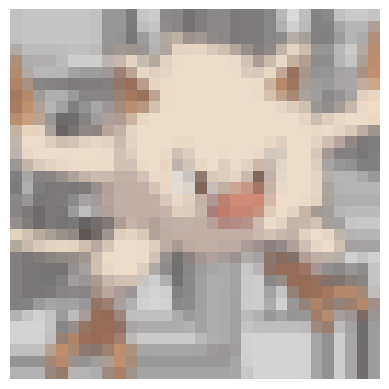

In [19]:
# Run this to test your data loader
images, labels = next(iter(train_dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)

In [20]:
PATH = 'data/images'
data_dir = PATH + '/test'

transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])
test_data = datasets.ImageFolder(data_dir, transform=transform)

class_counts = Counter(test_data.targets)
sample_weights = [1/class_counts[i] for i in test_data.targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
test_dataloader = torch.utils.data.DataLoader(test_data, sampler=sampler, batch_size=5)

<Axes: >

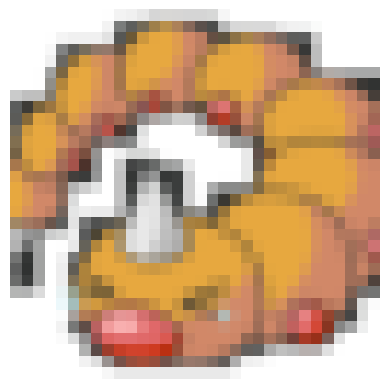

In [21]:
# Run this to test your data loader
images, labels = next(iter(test_dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)

In [22]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([5, 3, 32, 32])
Shape of y: torch.Size([5]) torch.int64


/var/folders/q3/64srm6ds41xd6nlgzcvd7ff80000gn/T/ipykernel_34134/3668034362.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  plt.imshow(np.fliplr(np.rot90(X.T, k=3, axes=(0, 1))), interpolation="nearest")


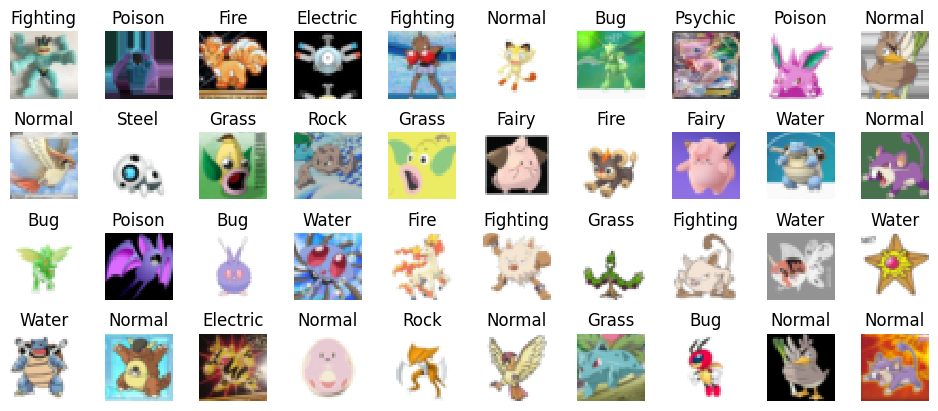

In [23]:
# Let's fetch a few items from the training set and visualize it

# Corresponding class names 
class_names = sorted(pokedex_relevant['Primary Type'].unique().tolist())

# Visualize dataset sample with random samples
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        selector_index = random.randint(0,len(training_data)-1)
        plt.subplot(n_rows, n_cols, index + 1)
        X, y = training_data[selector_index]
        plt.imshow(np.fliplr(np.rot90(X.T, k=3, axes=(0, 1))), interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [24]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(32*32*3,512),
                                               nn.ReLU(),
                                               nn.Linear(512,512),
                                               nn.ReLU(),
                                               nn.Linear(512,18),
                                               nn.ReLU())

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=18, bias=True)
    (5): ReLU()
  )
)


In [25]:
# weights based on number of instances in test data
#class_weights = torch.FloatTensor(weights)
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3

# Define a pytorch optimizer using stochastic gradient descent (SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [26]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    # set the model to train mode
    model.train()
    
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        
        # Compute training loss
        loss = loss_fn(pred,y)

        # Backpropagation
        optimizer.zero_grad()
        
        # Calculate model gradients from the loss and optimize the network
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * len(X)
        if batch % 100 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        losses.append(loss)
        
    return np.array(losses).mean()

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    # Set the model to eval mode
    model.eval()
    
    test_loss, correct = 0, 0
    with torch.no_grad():	# no_grad mode doesn't compute gradients
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred,y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

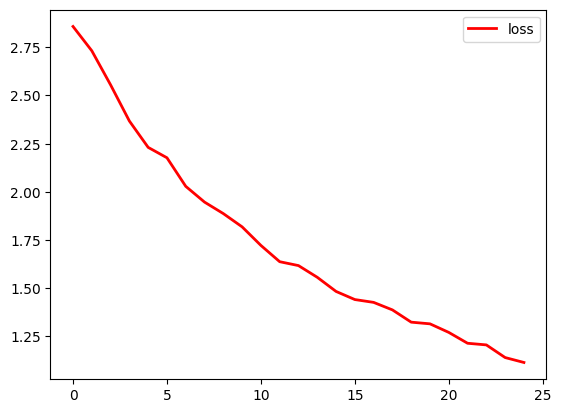

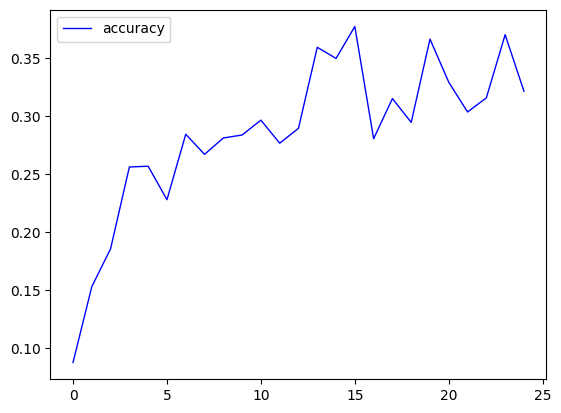

Done!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

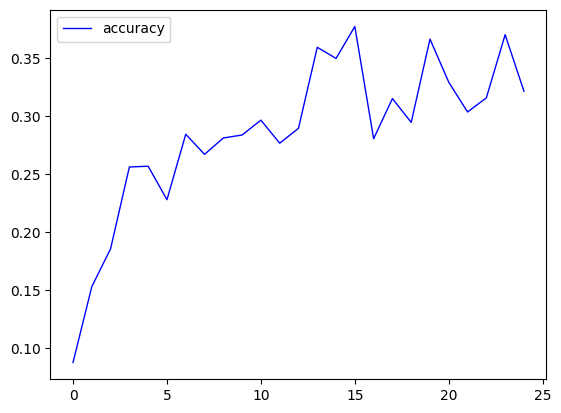

In [27]:
epochs = 25

# for plotting the training loss
history = {'losses': [], 'accuracies': []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['losses'].append(train(train_dataloader, model, loss_fn, optimizer))
    history['accuracies'].append(test(test_dataloader, model, loss_fn))
    
    plt.clf()
    fig1 = plt.figure()
    plt.plot(history['losses'], 'r-', lw=2, label='loss')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.clf()
    fig2 = plt.figure()
    plt.plot(history['accuracies'], 'b-', lw=1, label='accuracy')
    plt.legend()
#     display.clear_output(wait=True)
    display.display(plt.gcf())
print("Done!")

# Make predictions on random 40 test data items using the trained model and visualize them
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        selector_index = random.randint(0,len(test_data)-1)
        plt.subplot(n_rows, n_cols, index + 1)
        X, y = test_data[selector_index]
        y_pred = model(X.to(device)[None,...])
        y_pred = y_pred.argmax(1)
        plt.imshow(np.fliplr(np.rot90(X.T, k=3, axes=(0, 1))), interpolation="nearest")
        plt.axis('off')
        if y == y_pred:
            plt.title(class_names[y_pred], fontsize=12, color='b')
        else:
            plt.title(class_names[y_pred], fontsize=12, color='r')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [28]:
true_ys = []
pred_ys = []
for selector_index in range(len(test_data)):
    X, y = test_data[selector_index]
    y_pred = model(X.to(device)[None,...])
    y_pred = y_pred.argmax(1)
    y = class_names[y]
    y_pred = class_names[y_pred]
    true_ys.append(y)
    pred_ys.append(y_pred)

print("For test set:")
print("Confusion Matrix: ",
confusion_matrix(true_ys, pred_ys))

print ("Accuracy : ",
accuracy_score(true_ys, pred_ys)*100)

print("Report : ",
classification_report(true_ys, pred_ys))

true_ys = []
pred_ys = []
for selector_index in range(len(training_data)):
    X, y = training_data[selector_index]
    y_pred = model(X.to(device)[None,...])
    y_pred = y_pred.argmax(1)
    y = class_names[y]
    y_pred = class_names[y_pred]
    true_ys.append(y)
    pred_ys.append(y_pred)

print("For train set:")
print("Confusion Matrix: ",
confusion_matrix(true_ys, pred_ys))

print ("Accuracy : ",
accuracy_score(true_ys, pred_ys)*100)

print("Report : ",
classification_report(true_ys, pred_ys))

For test set:
Confusion Matrix:  [[19  8  1 15  4 20  6  0  5  6  5  0 11  7 11  1  0  3]
 [ 0  3  0  2  2  1  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  4  9  1  0  3  3  0  0  1  2  0  1  1  5  0  0  0]
 [ 0  2  3 37  2  9 13  0  5  0  6  0  5  2 14  2  1  0]
 [ 0  0  0  0 13  1  1  0  0  0  0  0  5  0  1  0  0  0]
 [ 1  5  0 10  2 30  2  0  1  0  7  0  7  1  6  0  1  2]
 [ 0  1  0  9  2  5 66  1  0  0 15  0 12  0  6  1  0  2]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  2  0  1  0  1  0  0 16  0  0  0  3  8  3  0  0  0]
 [ 5  2  5 17  2 10  1  1  0 45  5  4 17  3 10  0  4  4]
 [ 0  3  0  6  1  5  9  0  1  0 29  0 11  5  7  0  0  1]
 [ 0  0  2  4  1  3  7  0  0  0  0  9  0  1  3  0  0  1]
 [ 0  3  1 19 21 27 37  0  3  2 13  0 72  3 10  3  2  3]
 [ 2  3  5  6  3  6  0  0  4  1  5  2 14 55  3  3  0  5]
 [ 1  4  0  7  1  2  1  0  3  0  6  0 10  3 41  1  0  0]
 [ 0  3  3 10  3 16  4  0  1  2  7  0  9  2  8 18  1  0]
 [ 0  2  0  1  0  1  1  0  0  0  0  0  0  0  1  0  1  0

In [29]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        
        # Using the nn.Sequential function, define a 5 layers of convolutions
        self.conv_relu_stack =  nn.Sequential(nn.Conv2d(3,32, kernel_size=3, padding=1),
                                              nn.LeakyReLU(),
                                              nn.MaxPool2d(kernel_size=2),
                                              nn.Conv2d(32,64, kernel_size=3, padding=1),
                                              nn.LeakyReLU(),
                                              nn.MaxPool2d(kernel_size=2),
                                              nn.Conv2d(64,128, kernel_size=3, padding=1),
                                              nn.LeakyReLU(),
                                              nn.MaxPool2d(kernel_size=2),
                                              nn.Conv2d(128,256, kernel_size=3, padding=1),
                                              nn.LeakyReLU(),
                                              nn.MaxPool2d(kernel_size=2),
                                              nn.Conv2d(256,512, kernel_size=3, padding=1),
                                              nn.LeakyReLU())
        # with ReLU activation function
        # with sizes of input and output nodes as:
        # layer1: 1,32 , kernel size of 3, with padding of 1
        # layer2: 32, 64, kernel_size 3, with padding of 1
        # pooling layer 
        # with ReLU activation function
        # you can add more conv, pooling and relu layers
        # Last layer: in:512, out: 10 (for 10 output classes)
        self.linear = nn.Sequential(nn.Linear(2048,512),
                                    nn.LeakyReLU(),
                                    nn.Linear(512,18),
                                    nn.LeakyReLU())

    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): L

In [30]:
# Use cross-entropy loss as the loss function
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3

# Define a pytorch optimizer using stochastic gradient descent (SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

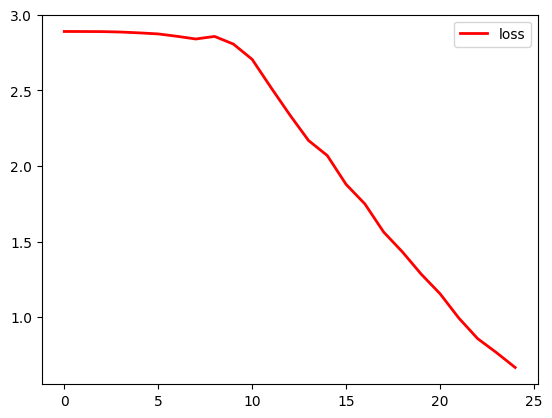

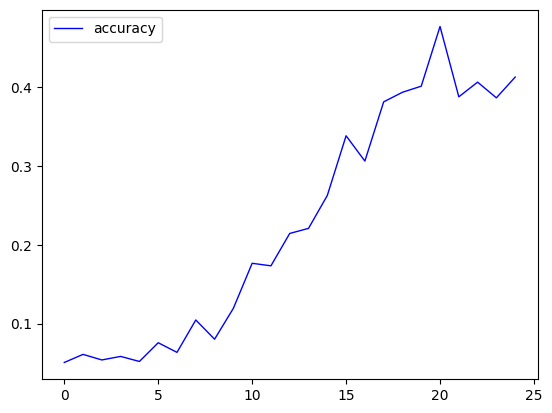

Done!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

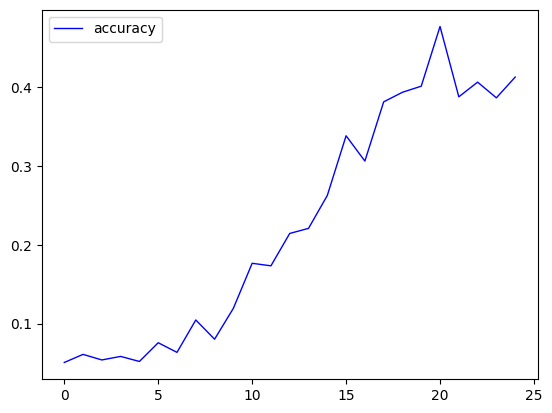

In [31]:
epochs = 25

# for plotting the training loss
history = {'losses': [], 'accuracies': []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['losses'].append(train(train_dataloader, model, loss_fn, optimizer))
    history['accuracies'].append(test(test_dataloader, model, loss_fn))
    
    plt.clf()
    fig1 = plt.figure()
    plt.plot(history['losses'], 'r-', lw=2, label='loss')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.clf()
    fig2 = plt.figure()
    plt.plot(history['accuracies'], 'b-', lw=1, label='accuracy')
    plt.legend()
#     display.clear_output(wait=True)
    display.display(plt.gcf())
print("Done!")  # likely could use more epochs

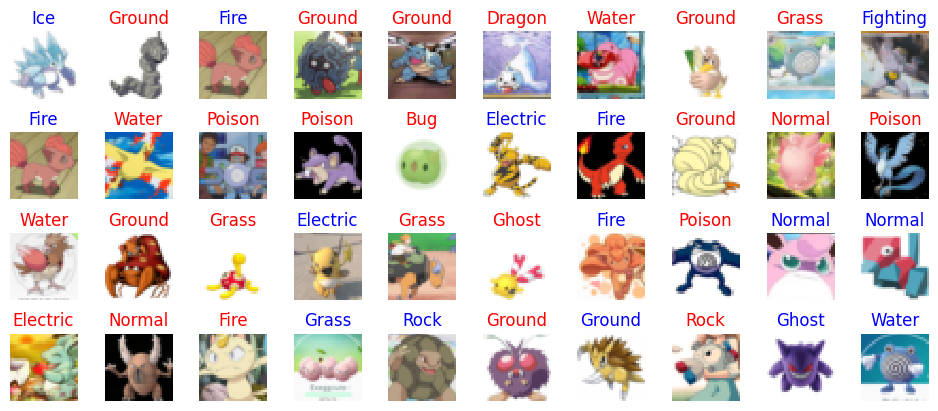

In [32]:
# Make predictions on random 40 test data items using the trained model and visualize them
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        selector_index = random.randint(0,len(test_data)-1)
        plt.subplot(n_rows, n_cols, index + 1)
        X, y = test_data[selector_index]
        y_pred = model(X.to(device)[None,...])
        y_pred = y_pred.argmax(1)
        plt.imshow(np.fliplr(np.rot90(X.T, k=3, axes=(0, 1))), interpolation="nearest")
        plt.axis('off')
        if y == y_pred:
            plt.title(class_names[y_pred], fontsize=12, color='b')
        else:
            plt.title(class_names[y_pred], fontsize=12, color='r')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

# Resnet

In [33]:
# RESIZE DATA
PATH = 'data/images'
data_dir = PATH + '/train'

transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
training_data = datasets.ImageFolder(data_dir, transform=transform)

class_counts = Counter(training_data.targets)
sample_weights = [1/class_counts[i] for i in training_data.targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_dataloader = torch.utils.data.DataLoader(training_data, sampler=sampler, batch_size=5)  # sampler=sampler

<Axes: >

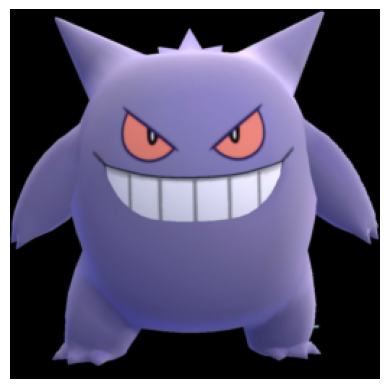

In [34]:
# Run this to test your data loader
images, labels = next(iter(train_dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)

In [35]:
PATH = 'data/images'
data_dir = PATH + '/test'

transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()])
test_data = datasets.ImageFolder(data_dir, transform=transform)

class_counts = Counter(test_data.targets)
sample_weights = [1/class_counts[i] for i in test_data.targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
test_dataloader = torch.utils.data.DataLoader(test_data, sampler=sampler, batch_size=5)

<Axes: >

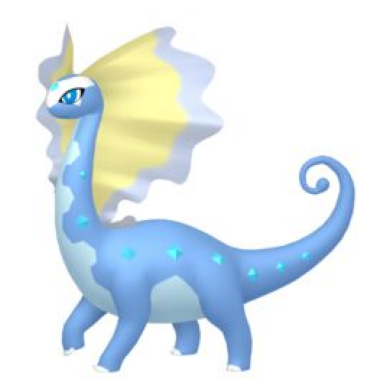

In [36]:
# Run this to test your data loader
images, labels = next(iter(test_dataloader))
# helper.imshow(images[0], normalize=False)
imshow(images[0], normalize=False)

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet152 = models.resnet152(pretrained=True).to(device)

/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
# Use cross-entropy loss as the loss function
loss_fn_resnet = nn.CrossEntropyLoss()
learning_rate = 1e-4

# Define a pytorch optimizer using stochastic gradient descent (SGD)
optimizer_resnet = torch.optim.SGD(resnet152.parameters(), lr=learning_rate, momentum=0.9)

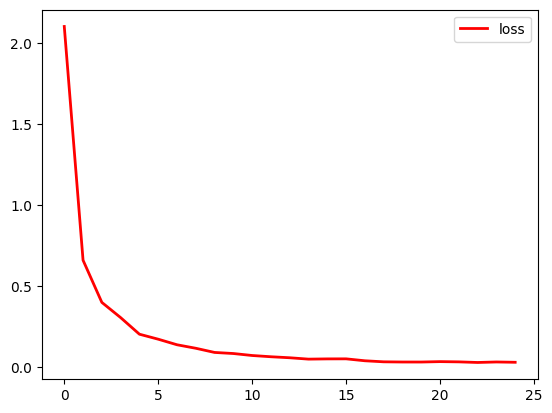

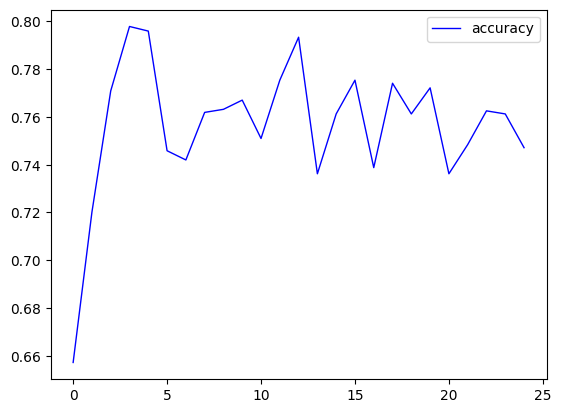

Done!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

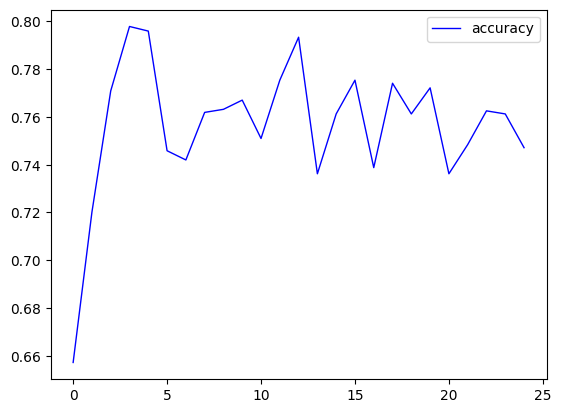

In [39]:
epochs = 25

# for plotting the training loss
history = {'losses': [], 'accuracies': []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['losses'].append(train(train_dataloader, resnet152, loss_fn_resnet, optimizer_resnet))
    history['accuracies'].append(test(test_dataloader, resnet152, loss_fn_resnet))
    
    plt.clf()
    fig1 = plt.figure()
    plt.plot(history['losses'], 'r-', lw=2, label='loss')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.clf()
    fig2 = plt.figure()
    plt.plot(history['accuracies'], 'b-', lw=1, label='accuracy')
    plt.legend()
#     display.clear_output(wait=True)
    display.display(plt.gcf())
print("Done!")

In [ ]:
# this model has been trained already over the course of many hours, so optionally just load the model in here
with open('outputs/resnet_pokemon_image_classifier_model.pkl', 'rb') as file:
    resnet152 = pickle.load(file)

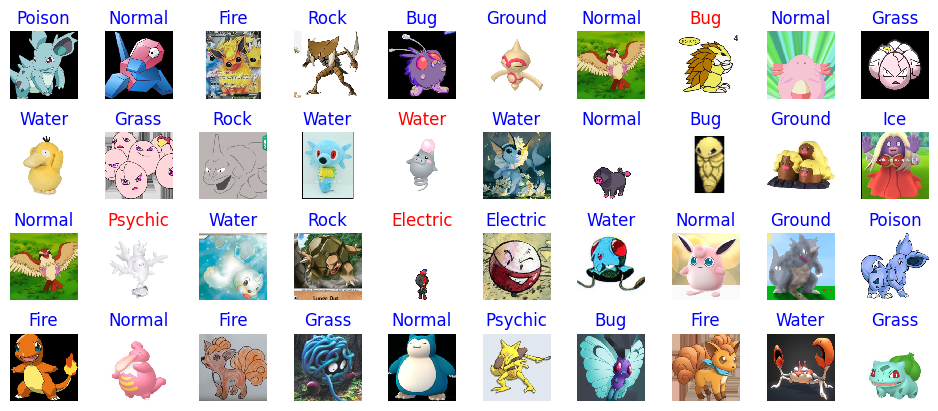

In [41]:
# Make predictions on random 40 test data items using the trained model and visualize them
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        selector_index = random.randint(0,len(test_data)-1)
        plt.subplot(n_rows, n_cols, index + 1)
        X, y = test_data[selector_index]
        y_pred = resnet152(X.to(device)[None,...])
        y_pred = y_pred.argmax(1)
        plt.imshow(np.fliplr(np.rot90(X.T, k=3, axes=(0, 1))), interpolation="nearest")
        plt.axis('off')
        if y == y_pred:
            plt.title(class_names[y_pred], fontsize=12, color='b')
        else:
            plt.title(class_names[y_pred], fontsize=12, color='r')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [42]:
# WOW! Resnet is insane!
true_ys = []
pred_ys = []
for selector_index in range(len(test_data)):
    X, y = test_data[selector_index]
    y_pred = resnet152(X.to(device)[None,...])
    y_pred = y_pred.argmax(1)
    y = class_names[y]
    y_pred = class_names[y_pred]
    true_ys.append(y)
    pred_ys.append(y_pred)

print("For test set:")
print("Confusion Matrix: ",
confusion_matrix(true_ys, pred_ys))

print ("Accuracy : ",
accuracy_score(true_ys, pred_ys)*100)

print("Report : ",
classification_report(true_ys, pred_ys))

true_ys = []
pred_ys = []
for selector_index in range(len(training_data)):
    X, y = training_data[selector_index]
    y_pred = resnet152(X.to(device)[None,...])
    y_pred = y_pred.argmax(1)
    y = class_names[y]
    y_pred = class_names[y_pred]
    true_ys.append(y)
    pred_ys.append(y_pred)

print("For train set:")
print("Confusion Matrix: ",
confusion_matrix(true_ys, pred_ys))

print ("Accuracy : ",
accuracy_score(true_ys, pred_ys)*100)

print("Report : ",
classification_report(true_ys, pred_ys))

For test set:
Confusion Matrix:  [[110   0   0   0   0   1   1   0   0   2   0   0   0   1   0   3   0   4]
 [  1   2   0   1   1   0   0   0   0   1   0   0   0   0   0   1   0   2]
 [  0   0  24   0   0   0   1   0   0   0   0   0   0   1   1   0   0   3]
 [  0   0   1  92   2   1   1   0   0   0   1   0   0   0   1   2   0   0]
 [  0   0   0   0  18   0   0   0   0   1   0   0   0   1   1   0   0   0]
 [  0   0   0   0   0  67   1   0   0   0   3   0   0   0   0   2   0   2]
 [  1   0   0   1   0   2 111   0   0   0   2   0   0   0   0   1   0   2]
 [  0   0   0   0   1   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [  2   0   0   0   0   1   0   0  25   0   0   0   0   1   1   1   0   3]
 [  2   0   0   0   1   0   0   0   0 129   0   0   1   0   0   1   0   1]
 [  1   0   0   0   0   0   2   0   0   1  68   0   0   0   2   3   0   1]
 [  0   0   0   0   0   0   1   0   0   1   0  26   0   0   0   1   0   2]
 [  1   1   0   2   1   1   2   0   0   1   2   0 197   3   1   3  

/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/albc99/anaconda3/envs/pokemon/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

For train set:
Confusion Matrix:  [[ 492    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0   35    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0  122    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0  404    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0   89    0    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0  299    0    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0  478    0    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    7    0    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    0  141    0    0    0    0    0
     0    0    0    0]
 [   0    0    0    0    0    0    0    0    0  543    0    0    0    0
     0    0    0    0]
 [   0    0    0